## Perform sentimental analysis on the Elon-musk tweets

In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import spacy
from tqdm.notebook import tqdm_notebook
# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
# ignoring all the warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))
# for showing all the plots inline
%matplotlib inline

C:\Users\kumar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[

In [2]:
# load the dataset
# load the dataset
tweets=pd.read_csv('D:\\execlr\\Assignments\\Assignment 11\\Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweet=tweets.copy()
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


## Data Exploration

In [3]:
# Number of Words
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


In [4]:
# Number of Character
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


In [5]:
#Average Word Length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()

,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


In [6]:
# Number of stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()

,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


In [7]:
# Number of special characters
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [8]:
# Number of numerics
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [9]:
# Number of Uppercase words
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()

,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [10]:
# Number of Rare Words
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

In [11]:
# Percentage of Links attached in the tweets
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

 Approx 32% of Musk tweets include URLs..

In [12]:
# Percentage of User Tags in the tweets
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

Approx 83% of Tweets in the available DataFrame contains UserTags

In [13]:
# Total tweets
print('Total tweets this DataFrame:', len(tweets.index), '\n')

Total tweets this DataFrame: 1999 



In [14]:
tweets.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)

In [15]:
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


In [16]:
# Spelling correction
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

In [17]:
TextBlob(tweets['Tweets'][3]).ngrams(1)

[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [18]:
TextBlob(tweets['Tweets'][2]).ngrams(2)

[WordList(['joerogan', 'Spotify']),
 WordList(['Spotify', 'Great']),
 WordList(['Great', 'interview'])]

In [19]:
TextBlob(tweets['Tweets'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

In [20]:
# Things on his mind
from nltk import word_tokenize
tokens = tweets.Tweets.map(word_tokenize)

def what_does_elon_think_about(x):
    x_l = x.lower()
    x_t = x.title()
    return tweets.loc[tokens.map(lambda sent: x_l in sent or x_t in sent).values]

In [21]:
what_does_elon_think_about('meme').Tweets.values.tolist()

['I am become meme,\nDestroyer of shorts']

In [22]:
what_does_elon_think_about('oil').Tweets.values.tolist()

['@BernieSanders That bs was pushed by oil &amp; gas interests to distract people from the $5 *trillion* per year they re\x85 https://t.co/pTAWt9dHHc']

In [23]:
what_does_elon_think_about('life').Tweets.values.tolist()

['@flcnhvy Tesla is responsible for 2/3 of all the personal &amp; professional pain in my life combined. But it was worth it.',
 'Life, the Universe and Everything https://t.co/1ZCzInfc4u',
 'This is a life leader launch, so more risk than normal https://t.co/EtFP9IELrf',
 '@Astronomiaum Life in glass domes at first. Eventually, terraformed to support life, like Earth.',
 '@peterrhague It\x92s designed to make life multiplanetary, otherwise extreme overkill for mere Earth sector activity!\x85 https://t.co/yjLTT8pEEu',
 '@teslaownersSV @toadmeister I\x92ve spent more than half my life in California &amp; love the state. But, frankly, I think\x85 https://t.co/s5xouoedjT',
 '@bamtheteslaman1 @cleantechnica Doesn\x92t seem to be any life in this solar system. Maybe under the ice of Europa or\x85 https://t.co/izk0v9Gi47',
 'Speedrunning Factorio in real life \x85',
 'Story of my life',
 '@teslavibes Couldn\x92t agree more \x97 major software improvements are already in place to extend its l

## Data Visualization

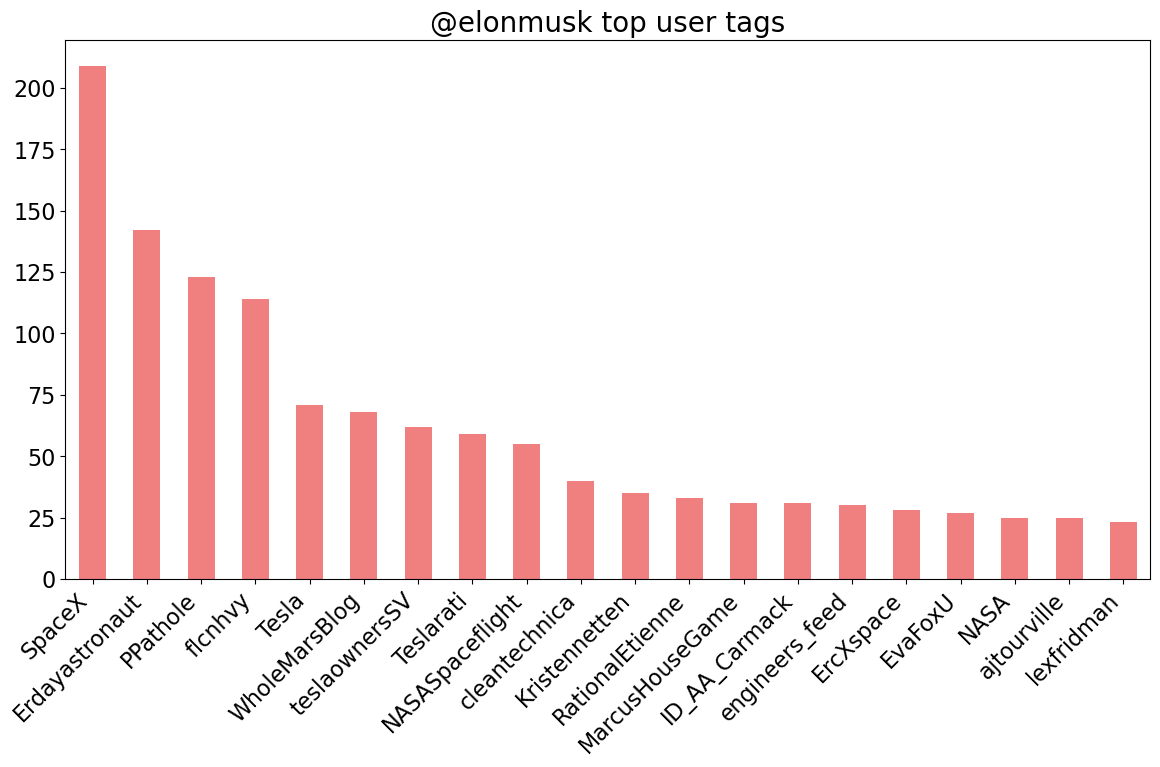

In [24]:
import itertools

c = list(
itertools.chain(
    *tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

## BasicText Preprocessing

In [25]:
# Collecting all the Tweets for Textual Pre-Processing
tweets=[Text.strip() for Text in tweets.Tweets] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [26]:
# Combining all the Tweets into Text
# Joining the list into one string/text
tweets_text=' '.join(tweets)
tweets_text[:1000]

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation. The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U

In [27]:
# Using TweetTokenizer to remove all the Twitter Username Handles
# remove Twitter username handles from a given twitter text. (Removes @usernames)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
tweets_tokens=tknzr.tokenize(tweets_text)
print(tweets_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with']


In [28]:
# Joining all the Tokenized words into Text/String
# Again Joining the list into one string/text
tweets_tokens_text=' '.join(tweets_tokens)
tweets_tokens_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with https://t.co/3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to 

In [29]:
# Removing all the Punctuations fromt the Combined Text
# Remove Punctuations 
no_punc_text=tweets_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox  httpstco9WFKMYu2oj Frodo was the underdoge  All thought he would fail  Himself most of all  httpstcozGxJFDzzrM Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with httpstco3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha httpstcoFc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Ga

In [30]:
# Removing all the URL's from the Text
# remove https or url within text
import re
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission   Yes Once we can predict cash flow reason

In [31]:
# Again Tokenizing Text into individual words for further pre-processing
import nltk.data
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be']


In [32]:
# Tokens count
len(text_tokens)

17847

In [33]:
# Removing the Stopwords from the Text
# Remove Stopwords
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[:100])

['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission']


In [34]:
# Making the Text in Lowercase
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[:100])

['alien', 'ray', 'tracing', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tried', 'great', 'interview', 'doge', 'underestimated', 'congratulations', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thanks', 'indeed', 'tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'sent', 'just', 'agree', 'clubhouse', 'it', 'getting', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'thanks', 'fixing', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'your', 'app', 'sucks', 'rt', 'nasa', 'selected', 'falcon', 'heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'gateway', 'together', 'one', 'mission']


In [35]:
# Stemming the Text using NLTK Library
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tri', 'great', 'interview', 'doge', 'underestim', 'congratul', 'tesla', 'china', 'amaz', 'execut', 'last', 'year', 'now', 'next', 'even', 'happi', 'new', 'year', 'ox', 'frodo', 'underdog', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'inde', 'tweet', 'definit', 'repres', 'realworld', 'time', 'alloc', 'the', 'entertain', 'outcom', 'like', 'just', 'sent', 'just', 'agre', 'clubhous', 'it', 'get', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definit', 'issu', 'sentenc', 'seem', 'bit', 'high', 'thank', 'fix', 'pleas', 'unlock', 'account', 'thi', 'true', 'power', 'ani', 'crypto', 'wallet', 'give', 'privat', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavi', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'togeth', 'one', 'mission']


In [36]:
# Lemmatization of Text data using Spacy library
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lower_words))
print(doc[:100])

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission


In [37]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'think', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree', 'clubhouse', 'it', 'get', 'real', 'buy', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issue', 'sentencing', 'seem', 'bit', 'high', 'thank', 'fix', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavy', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'together', 'one', 'mission']


In [38]:
clean_tweets=' '.join(lemmas)
clean_tweets[:1000]

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all think would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto wallet give private key avoid cost your app suck rt nasa select falcon heavy launch first two element lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex need pass deep chasm negative cash flow next year low cost per ton carbon sequester net value product make must scalable g it mean price country only difference taxis ship this intend earth may idea apply mars xprize team manage 100 m 

### Generate Word Cloud

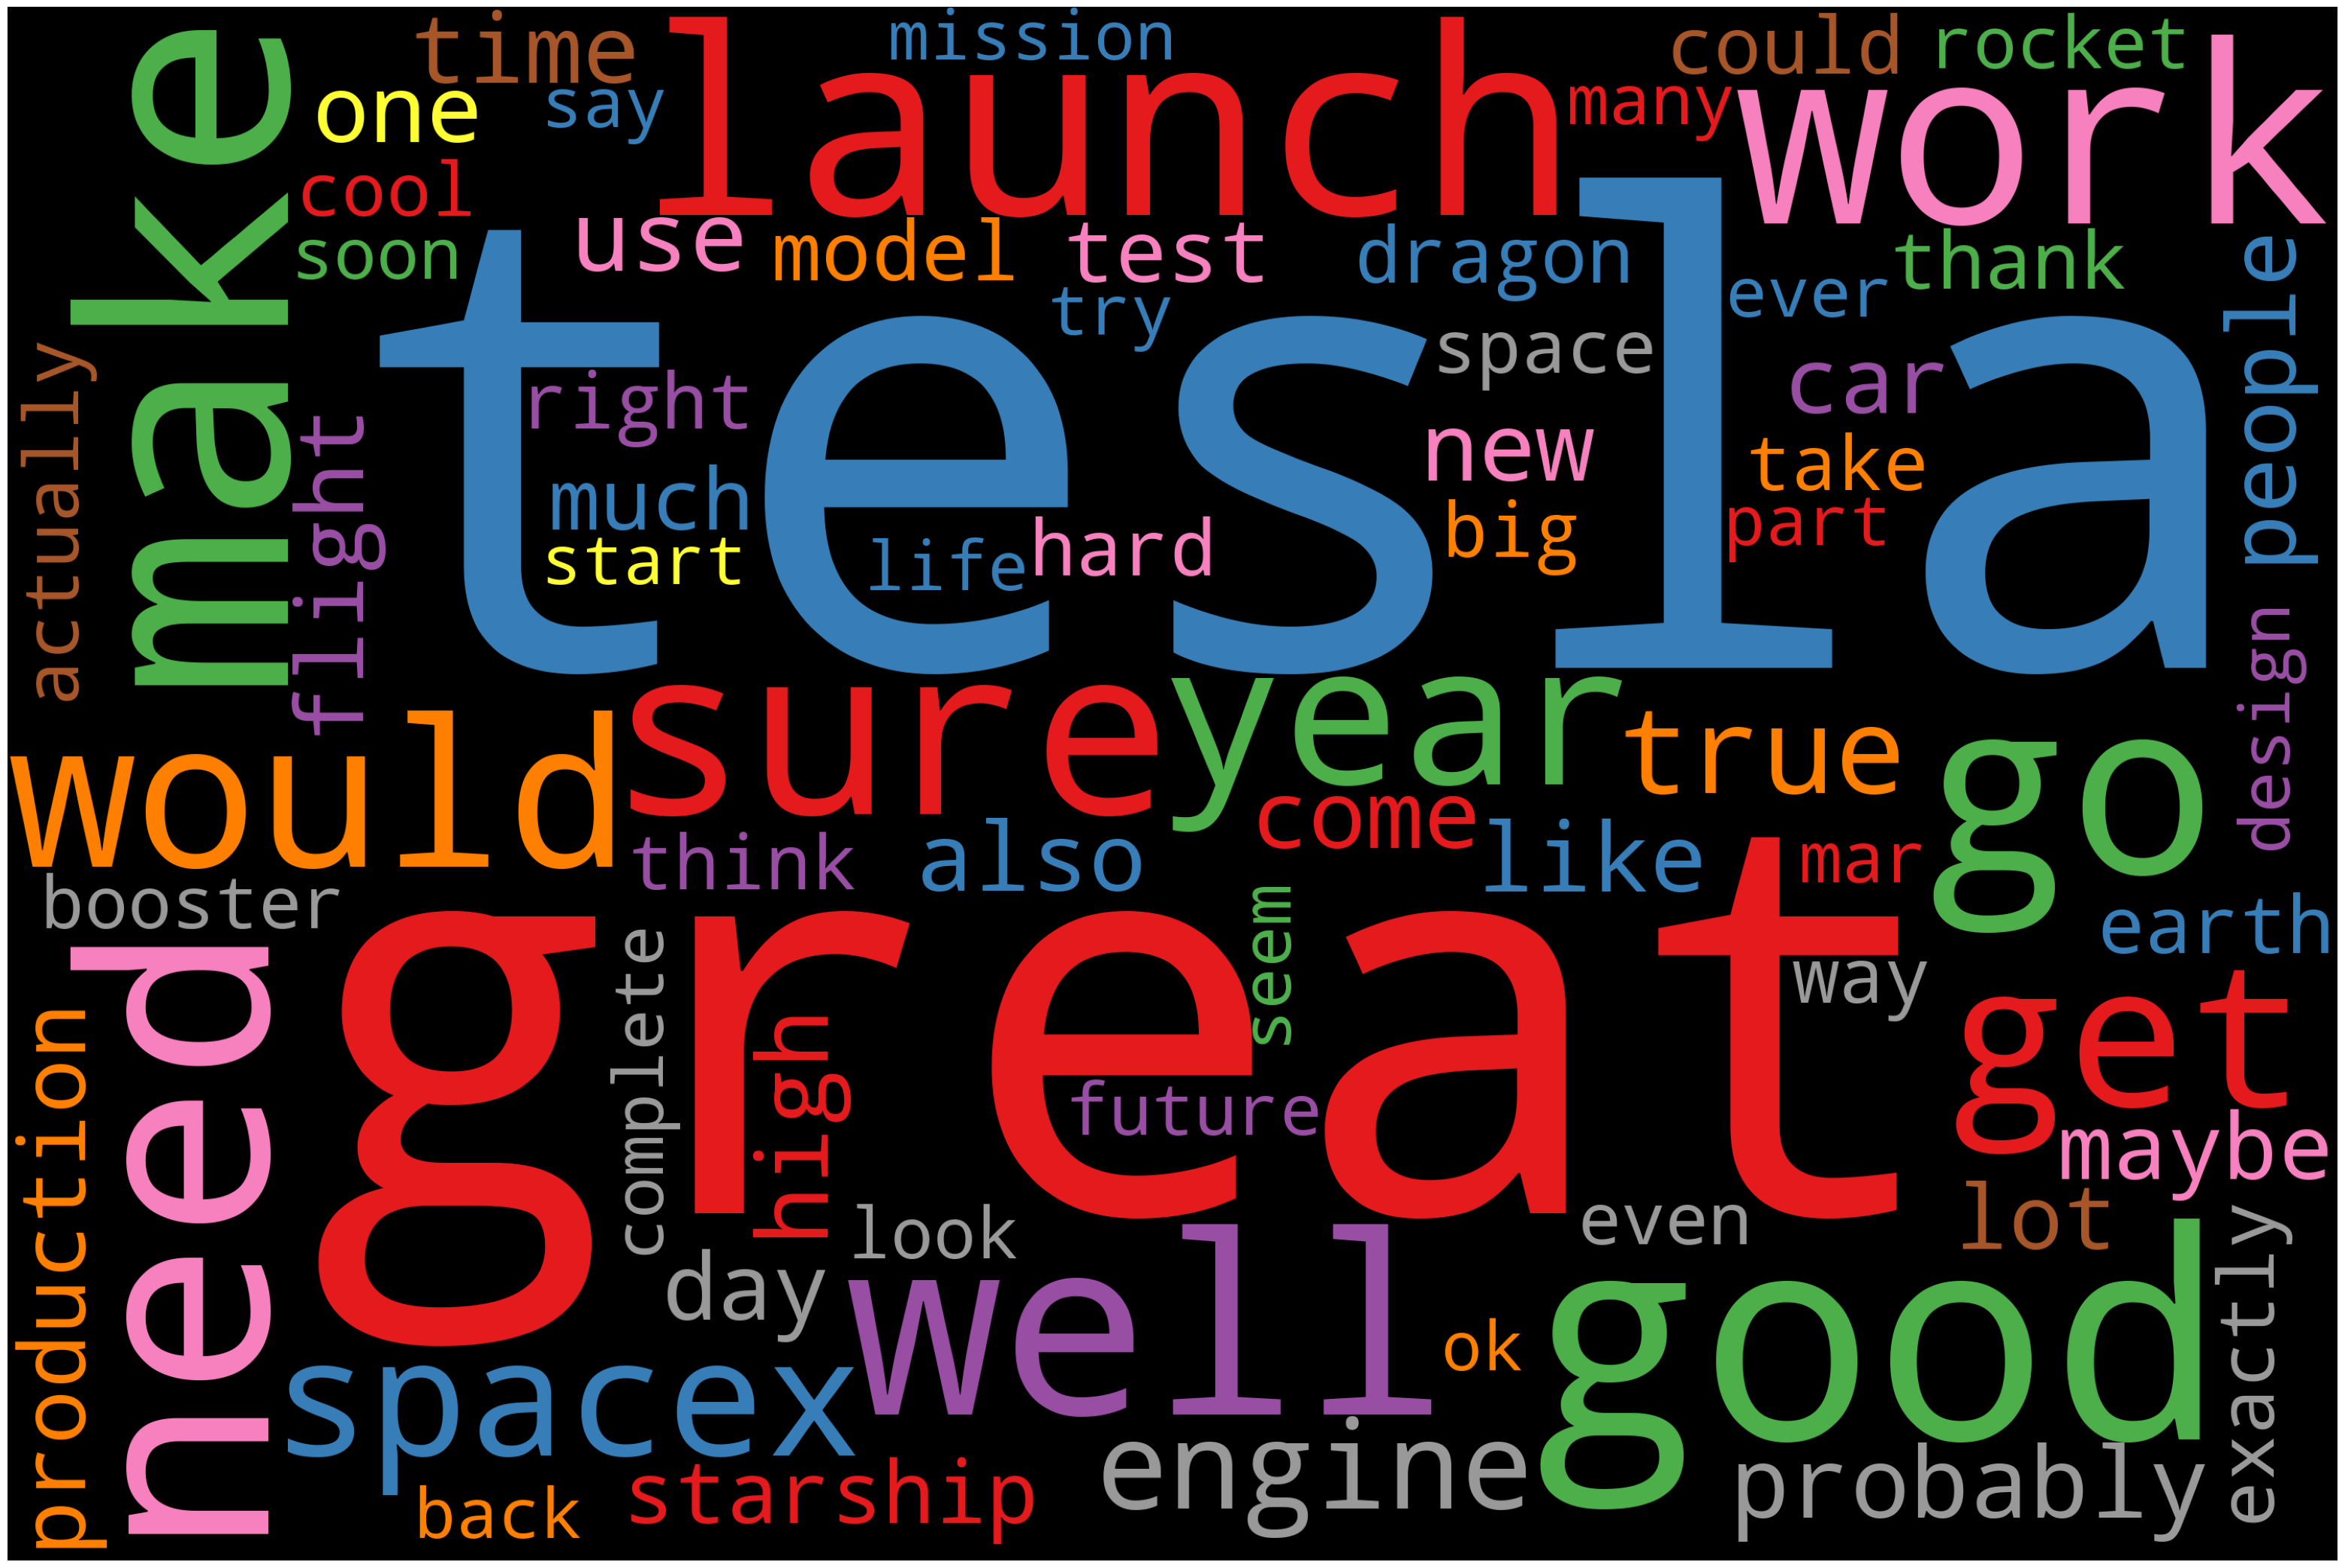

In [39]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')
wordcloud=WordCloud(width=3000,height=2000,background_color='black',max_words=70,
                   colormap='Set1',stopwords=my_stop_words).generate(clean_tweets)
plot_cloud(wordcloud)

##  Text Pre-processing Techniques 

In [40]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [41]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweet['Tidy_Tweets'] = np.vectorize(remove_pattern)(tweet['Tweets'], "@[\w]*")
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [42]:
# Removing links (http | https)
cleaned_tweets = []

for index, row in tweet.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tidy_Tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweet['Tidy_Tweets'] = cleaned_tweets
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [43]:
# Removing tweets with empty text
tweet = tweet[tweet['Tidy_Tweets']!='']
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [44]:
# Dropping duplicate rows
tweet.drop_duplicates(subset=['Tidy_Tweets'], keep=False)
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [45]:
# Resetting index
tweet =  tweet.reset_index(drop=True)
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,Great interview!
3,@gtera27 Doge is underestimated,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...","Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,The most entertaining outcome is the most likely


In [46]:
# Removing Punctuations, Numbers and Special characters
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [47]:
tweet['Tidy_Tweets'] = tweet['Tidy_Tweets'].apply(lambda x: clean_text(x))
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


In [48]:
# Function to remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [49]:
tweet['Tidy_Tweets']=tweet['Tidy_Tweets'].apply(lambda x: remove_emoji(x))
tweet.head(10)

,Tweets,Tidy_Tweets
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


In [50]:
tweet['tokenized_tweets'] = tweet['Tidy_Tweets'].apply(lambda x: nltk.word_tokenize(x))
tweet.head(10)

,Tweets,Tidy_Tweets,tokenized_tweets
0,@kunalb11 Im an alien,im an alien,"[im, an, alien]"
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,"[ray, tracing, on, cyberpunk, with, hdr, is, n..."
2,@joerogan @Spotify Great interview!,great interview,"[great, interview]"
3,@gtera27 Doge is underestimated,doge is underestimated,"[doge, is, underestimated]"
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,"[congratulations, tesla, china, for, amazing, ..."
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,"[happy, new, year, of, the, ox]"
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,"[frodo, was, the, underdoge, all, thought, he,..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,"[haha, thanks]"
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,"[indeed, tweets, definitely, do, not, represen..."
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,"[the, most, entertaining, outcome, is, the, mo..."


In [51]:
tweet.drop(['tokenized_tweets'],axis=1,inplace=True)

In [52]:
# Removing Stop words
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')
sw_list = ['i’m','\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
cleaned_tweets = []

for index, row in tweet.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Tidy_Tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweet['absolute_tidy_tweets'] = cleaned_tweets
tweet.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulations tesla china amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought would fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,indeed tweets definitely represent realworld t...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome likely


In [53]:
# Tokenize 'absolute_tidy_tweets'
tokenized_tweet = tweet['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head(10)

0                                         [im, alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulations, tesla, china, amazing, execu...
5                               [happy, new, year, ox]
6             [frodo, underdoge, thought, would, fail]
7                                             [thanks]
8    [indeed, tweets, definitely, represent, realwo...
9                      [entertaining, outcome, likely]
Name: absolute_tidy_tweets, dtype: object

In [54]:
# Converting words to Lemma
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head(10)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0                                         [im, alien]
1     [ray, tracing, cyberpunk, hdr, nextlevel, tried]
2                                   [great, interview]
3                               [doge, underestimated]
4    [congratulation, tesla, china, amazing, execut...
5                               [happy, new, year, ox]
6             [frodo, underdoge, thought, would, fail]
7                                             [thanks]
8    [indeed, tweet, definitely, represent, realwor...
9                      [entertaining, outcome, likely]
Name: absolute_tidy_tweets, dtype: object

In [55]:
# Joining all tokens into sentences
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweet['absolute_tidy_tweets'] = tokenized_tweet
tweet.head(10)

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought would fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent real...,indeed tweet definitely represent realworld ti...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome likely


###  Basic Feature Extaction

In [56]:
# Applying bag of Words without N grams
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
tweetscv=cv.fit_transform(lemmas)

In [57]:
print(cv.get_feature_names()[109:200])

['aber', 'able', 'abo', 'aboard', 'abort', 'about', 'above', 'absence', 'absolute', 'absolutely', 'absorb', 'absorption', 'absurd', 'absurdly', 'ac', 'academia', 'accel', 'accelera', 'accelerate', 'acceleration', 'accelerator', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidental', 'accommodate', 'account', 'accura', 'accuracy', 'accurate', 'ace', 'achieve', 'achievement', 'achy', 'acquisition', 'across', 'action', 'active', 'activity', 'actual', 'actuall', 'actually', 'actuary', 'adagio', 'add', 'additive', 'address', 'administer', 'adult', 'advanc', 'advance', 'advanced', 'advantage', 'adventure', 'advertise', 'advice', 'advise', 'aero', 'afb', 'affair', 'affect', 'affordable', 'africa', 'after', 'afternoon', 'age', 'ago', 'agony', 'agree', 'ah', 'ahead', 'ahem', 'ai', 'aim', 'aiming', 'air', 'aircraft', 'airplane', 'ak', 'aka', 'alert', 'alexander', 'algo', 'algorithm', 'alien', 'aliens', 'align', 'all', 'allocati']


C:\Users\kumar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
print(cv.get_feature_names()[:100])

['000', '005', '10', '100', '1000', '10000', '107', '10x', '11', '12', '122', '13', '130', '14', '140', '149', '15', '150', '155', '16', '162', '17', '18', '1880s', '1b', '1st', '20', '200', '2007', '2008', '2009', '2012', '2017', '2020', '2021', '2024', '2026', '2030', '20k', '210', '218', '21st', '22', '225', '23', '230', '24', '240', '25', '250', '250kw', '25gunsteslacom', '25k', '25th', '28', '28th', '29', '2k', '2nd', '2v', '30', '300', '301', '304', '304l', '31', '33', '330', '360', '37', '3800', '394', '39a', '3d', '3rd', '40', '400', '42', '420', '4227', '430', '43rd', '445', '448', '4530', '4680', '479000', '48', '4d', '4th', '50', '50000', '50k', '60', '60000', '65', '69420', '6f', '6k', '727']


In [59]:
print(tweetscv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [60]:
# CountVectorizer with N-grams (Bigrams & Trigrams)
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(tweet))):
    review = re.sub('[^a-zA-Z]', ' ', tweet['absolute_tidy_tweets'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1938 [00:00<?, ?it/s]

In [61]:
corpus[3]

'doge underestim'

In [62]:
# Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [63]:
 X.shape

(1938, 5000)

In [64]:
cv.get_feature_names()[:20]

['aber',
 'abl',
 'abort',
 'absolut',
 'absurd',
 'acceler',
 'accept',
 'access',
 'accur',
 'achiev',
 'across',
 'activ',
 'actual',
 'ad',
 'add',
 'address',
 'advanc',
 'advantag',
 'africa',
 'age']

In [65]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [66]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names())
count_df

,aber,abl,abort,absolut,absurd,acceler,accept,access,accur,achiev,...,year get,year support,year sure,yesterday,yet,yup,zero,zero death,zero death oct,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1934,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(tweet))):
    review = re.sub('[^a-zA-Z]', ' ', tweet['absolute_tidy_tweets'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1938 [00:00<?, ?it/s]

In [68]:
corpus[3]

'doge underestim'

In [69]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [70]:
X.shape

(1938, 5000)

In [71]:
tfidf_v.get_feature_names()[:20]

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aber',
 'abl',
 'abort',
 'absolut',
 'absurd',
 'acceler',
 'accept',
 'access',
 'accur',
 'achiev',
 'across',
 'activ',
 'actual',
 'ad',
 'add',
 'address',
 'advanc',
 'advantag',
 'africa',
 'age']

In [72]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [73]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names())
count_df

,aber,abl,abort,absolut,absurd,acceler,accept,access,accur,achiev,...,year get,year support,year sure,yesterday,yet,yup,zero,zero death,zero death oct,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1934,0.0,0.0,0.0,0.0,0.0,0.0,0.341156,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1935,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1936,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Named Entity Recognition (NER)

In [74]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=clean_tweets[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [75]:
for token in doc_block[:50]:
    print(token,token.pos_)

alien PROPN
ray NOUN
trace NOUN
cyberpunk PROPN
hdr PROPN
nextlevel NOUN
have AUX
try VERB
great ADJ
interview NOUN
doge X
underestimate PROPN
congratulation PROPN
tesla PROPN
china PROPN
amazing ADJ
execution NOUN
last ADJ
year NOUN
now ADV
next ADV
even ADV
happy ADJ
new ADJ
year NOUN
ox NOUN
frodo NOUN
underdoge PROPN
all PRON
think VERB
would AUX
fail VERB
himself PRON
haha PROPN
thank VERB
indeed ADV
tweet NOUN
definitely ADV
represent VERB
realworld PROPN
time NOUN
allocation NOUN
the DET
entertaining ADJ
outcome NOUN
likely ADV
just ADV
send VERB
just ADV
agree VERB


In [76]:
# Filtering the nouns and verbs only
one_block=clean_tweets
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['booster', 'improve', 'ship', 'booster', 'mass', 'work', 'tonight', 'ðogecoin', 'video', 'people', 'speak', 'image', 'reflect', 'time', 'cost', 'people', 'rain', 'pain', 'let', 'come', 'crypto', 'simplicity', 'genius', 'decade', 'work', 'look', 'note', 'email', 'text', 'lesson', 'learn', 'earth', 'time', 'tell', 'story', 'tesla', 'read', 'kingdom', 'hear', 'name', 'year', 'dogecake', 'thing', 'restaurant', 'hang', 'currency', 'earth', 'scratch', 'destiny', 'franz', 'say', 'ship', 'landing', 'burn', 'solution', 'greate', 'use', 'gas', 'maneuvering', 'rcs', 'thruster', 'seem', 'raptor', 'launch', 'mission', 'collect', 'galaxy', 'explore', 'launch', 'starlink', 'satellite', 'orbit', 'mission', 'pad', '39a', 'deck', 'default', 'engine', 'lever', 'arm', 'shut', 'engine', 'point', 'flameout', 'risk', 'start', 'engine', 'shut', 'need', 'land', 'become', 'destroyer', 'happen', 'sandstorm', 'masterpiece', 'dumb', 'time', 'try', 'pull', 'method']


In [77]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,launch,64
1,make,64
2,year,49
3,work,48
4,go,47
5,need,42
6,come,39
7,get,38
8,day,38
9,time,37


<AxesSubplot:title={'center':'Top 10 nouns and verbs'}, xlabel='word'>

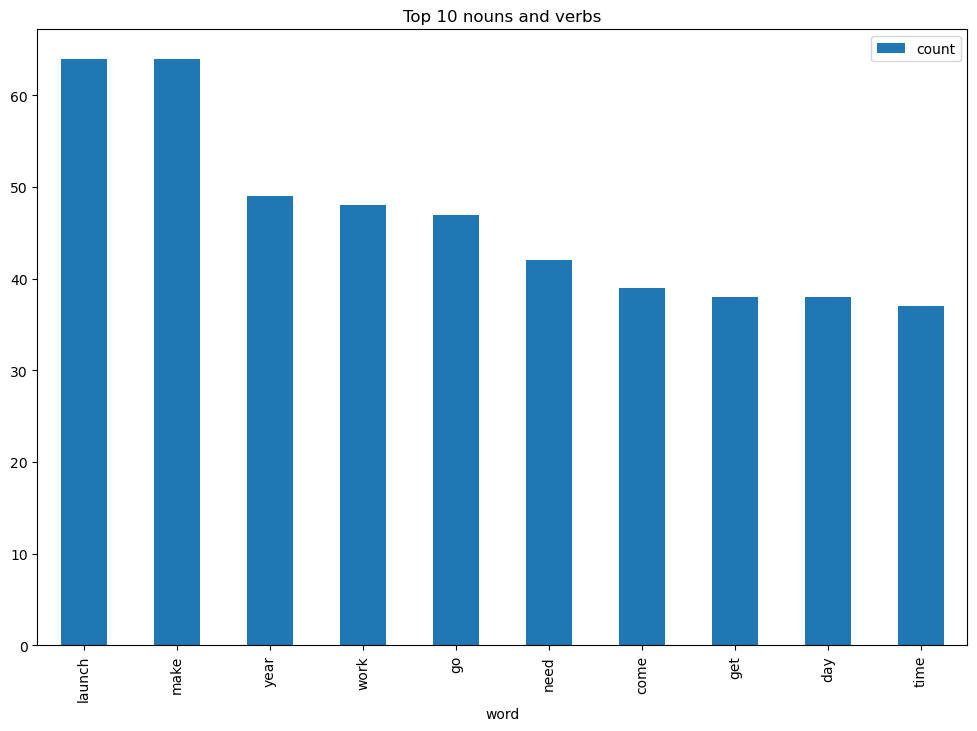

In [78]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

### Feature Extraction

In [79]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweet['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweet['absolute_tidy_tweets'])

In [80]:
tweet

,Tweets,Tidy_Tweets,absolute_tidy_tweets
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...
...,...,...,...
1933,"@flcnhvy True, it sounds so surreal, but the n...",true it sounds so surreal but the negative pro...,true sound surreal negative propaganda still a...
1934,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms amp conditions befo...,make sure read ur term amp condition clicking ...
1935,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,samwise gamgee
1936,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is,altho dumb dumber


### Fetch sentiments

In [81]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [82]:
# Using NLTK's SentimentIntensityAnalyzer
sentiments_using_SIA = tweet.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,absolute_tidy_tweets
pos,1737
neg,201


In [83]:
tweet.Tidy_Tweets[3]

'doge is underestimated'

In [84]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(tweet.absolute_tidy_tweets[3])

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}

In [85]:
df=pd.DataFrame()
df['Tweets'] = tweet.absolute_tidy_tweets
df['scores'] = tweet['Tidy_Tweets'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Tweets,scores
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [86]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [87]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Tweets,scores,compound,sentiment
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,ray tracing cyberpunk hdr nextlevel tried,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulation tesla china amazing execution l...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive
...,...,...,...,...
1933,true sound surreal negative propaganda still a...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative
1934,make sure read ur term amp condition clicking ...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive
1935,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1936,altho dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative


In [88]:
tweet.describe()

,Tweets,Tidy_Tweets,absolute_tidy_tweets
count,1938,1938,1938
unique,1936,1661,1624
top,The most entertaining outcome is the most likely,,
freq,2,80,124


In [89]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp.style.background_gradient(cmap='rainbow')

,sentiment,Tweets
2,Positive,873
1,Neutral,836
0,Negative,229


<AxesSubplot:xlabel='sentiment', ylabel='count'>

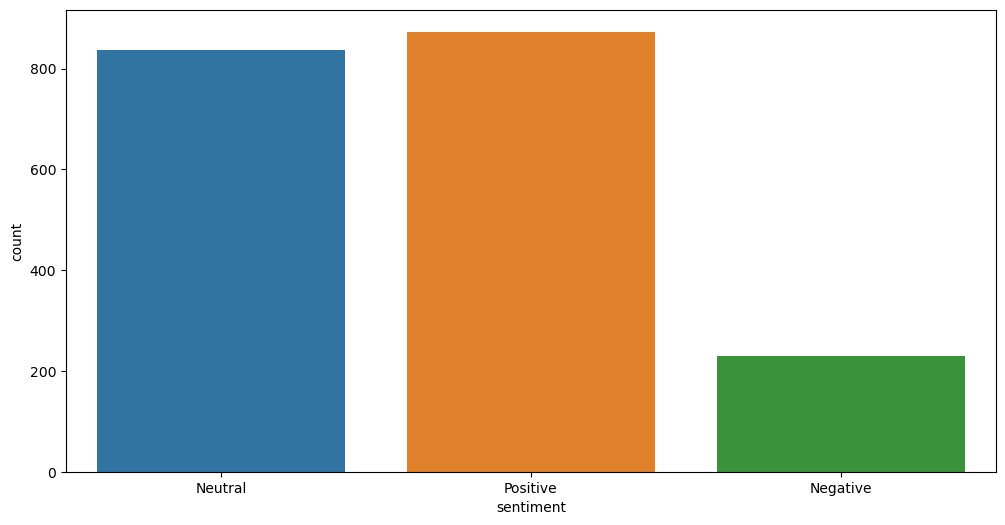

In [90]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

C:\Users\kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

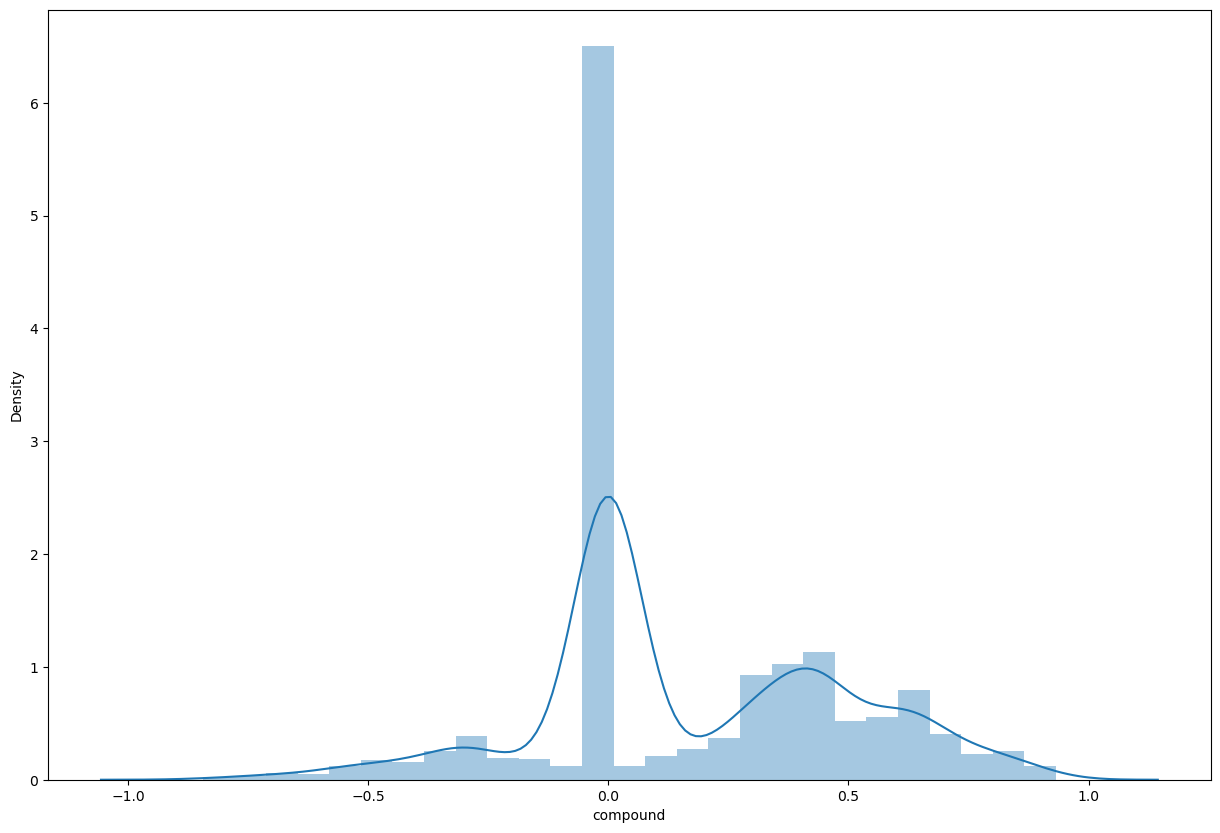

In [91]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(15,10))
sns.distplot(df['compound'])

<AxesSubplot:ylabel='compound'>

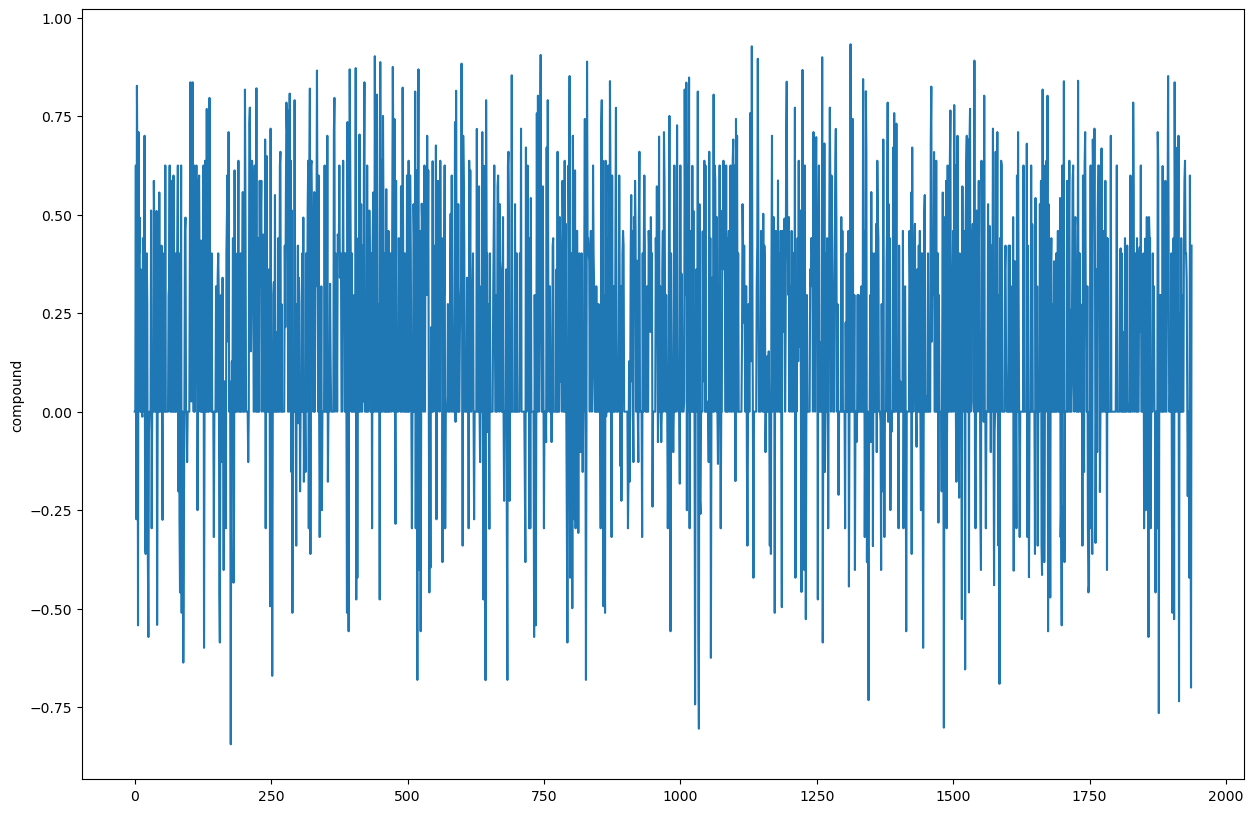

In [92]:
# Plotting the line plot for sentiment value of whole review
plt.figure(figsize=(15,10))
sns.lineplot(y='compound',x=df.index,data=df)

In [93]:
df['word_count'] = df['Tweets'].apply(lambda x: len(str(x).split(" ")))
df[['Tweets','word_count']].head()

,Tweets,word_count
0,im alien,2
1,ray tracing cyberpunk hdr nextlevel tried,6
2,great interview,2
3,doge underestimated,2
4,congratulation tesla china amazing execution l...,9


<AxesSubplot:title={'center':'Sentence sentiment value to sentence word count'}, xlabel='word_count', ylabel='compound'>

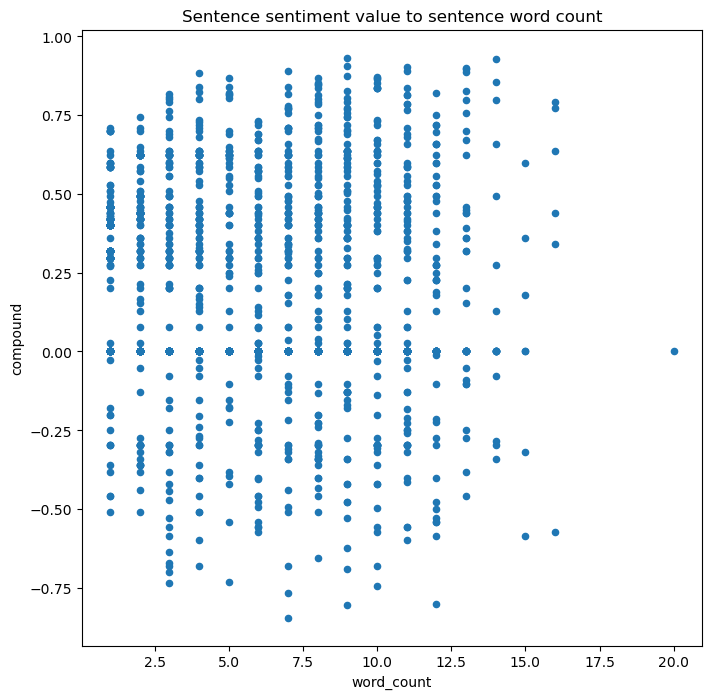

In [94]:
# Correlation analysis
df.plot.scatter(x='word_count',y='compound',figsize=(8,8),title='Sentence sentiment value to sentence word count')

In [95]:
# Using TextBlob
sentiments_using_textblob = tweet.absolute_tidy_tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,absolute_tidy_tweets
pos,1739
neg,199


In [96]:
tweet['sentiment'] = sentiments_using_SIA
tweet.head()

,Tweets,Tidy_Tweets,absolute_tidy_tweets,sentiment
0,@kunalb11 Im an alien,im an alien,im alien,pos
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray tracing on cyberpunk with hdr is nextlevel...,ray tracing cyberpunk hdr nextlevel tried,pos
2,@joerogan @Spotify Great interview!,great interview,great interview,pos
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated,neg
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execut...,congratulation tesla china amazing execution l...,pos


### Story Generation and Visualization

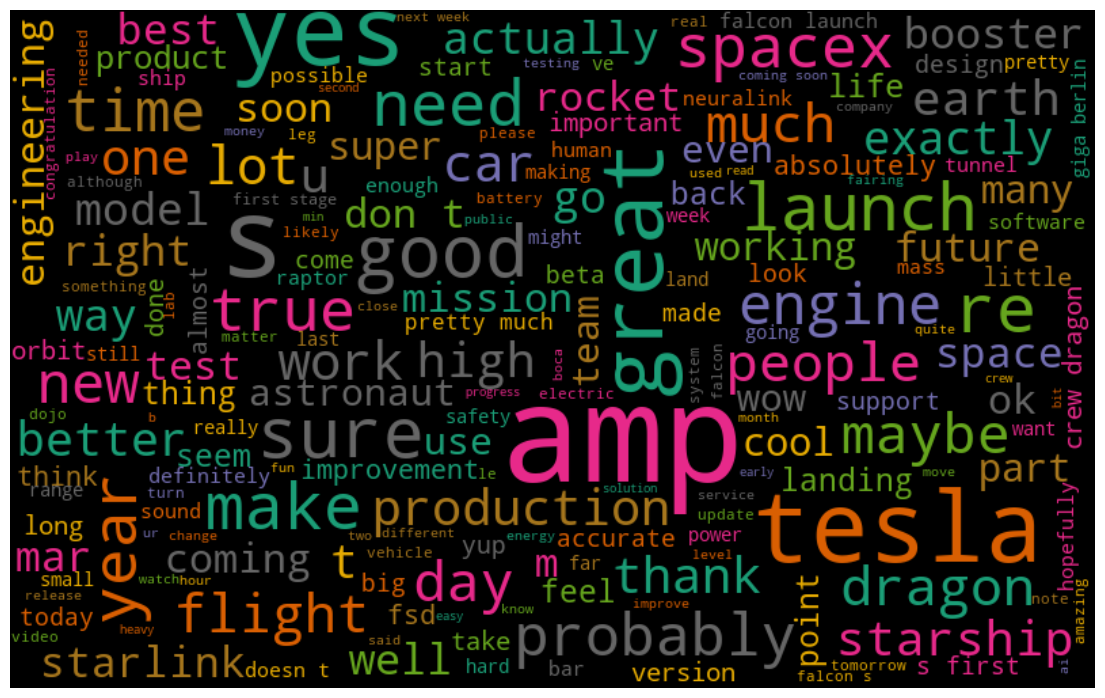

In [97]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
all_words = ' '.join([text for text in tweet['absolute_tidy_tweets'][tweet.sentiment == 'pos']])
generate_wordcloud(all_words)

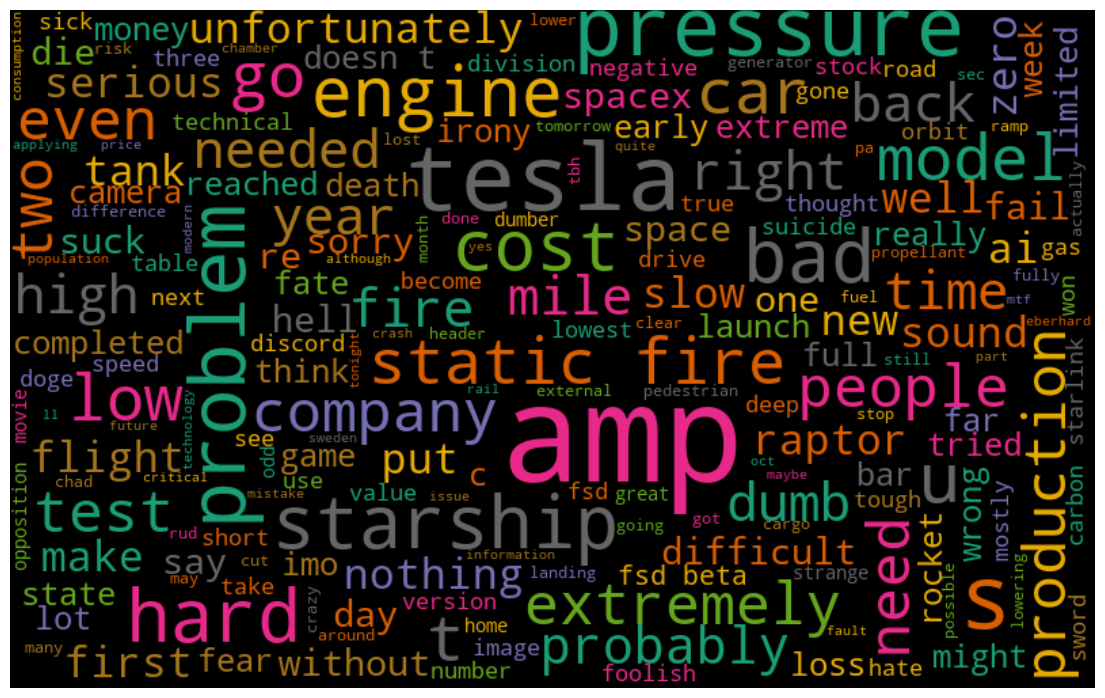

In [98]:
# Most common words in negative tweets
all_words = ' '.join([text for text in tweet['absolute_tidy_tweets'][tweet.sentiment == 'neg']])
generate_wordcloud(all_words)

### Model Building: Sentiment Analysis

In [99]:
target_variable = tweet['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [100]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [101]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

Accuracy Score - 0.6632302405498282


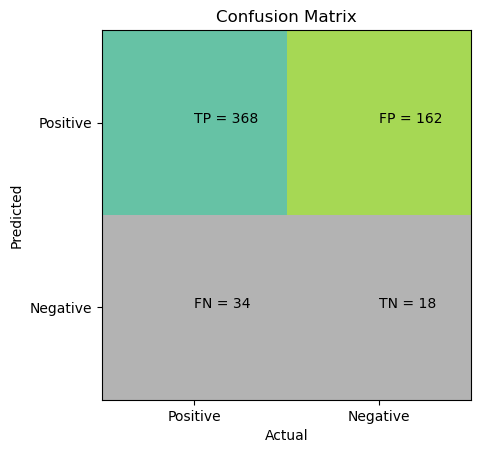

In [102]:
# Predictions on 'key words' based features
# BOW word features
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.6597938144329897


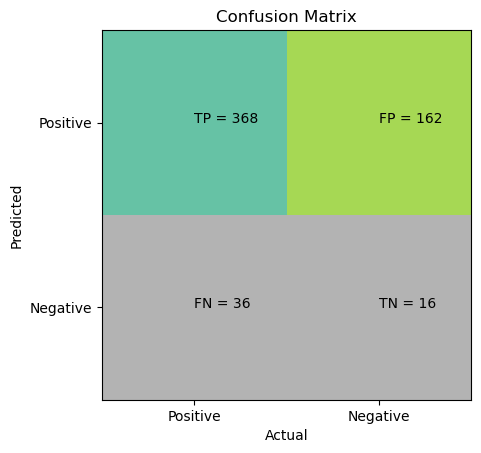

In [103]:
# TF-IDF word features
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

In [104]:
tweet['sentiment_binary'] = tweet['sentiment'].apply(lambda x: 0 if x=='neg' else 1)
pipeline_ls = make_pipeline(CountVectorizer(max_df=0.90, min_df=2, tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
X_train, X_test, y_train, y_test = train_test_split(tweet.absolute_tidy_tweets, tweet.sentiment_binary)
pipeline_ls.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.9, min_df=2, stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [105]:
pipeline_ls.score(X_test,y_test) 

0.8989690721649485